In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/credit/creditcard.csv")
#data = data.drop(columns=['id'])
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'Class'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
model_ctgan = FPGANSynthesizer(epochs=25, verbose=True)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data)

Epoch 1, Loss G: -0.1422,Loss D: -0.4280
Epoch 2, Loss G: -0.1789,Loss D: -0.3249
Epoch 3, Loss G: -0.1843,Loss D:  0.1032
Epoch 4, Loss G: -0.1570,Loss D: -0.1116
Epoch 5, Loss G: -0.0891,Loss D: -0.3431
Epoch 6, Loss G: -0.1280,Loss D: -0.7032
Epoch 7, Loss G: -0.1751,Loss D: -0.5676
Epoch 8, Loss G: -0.1442,Loss D: -0.8067
Epoch 9, Loss G: -0.0947,Loss D: -0.7573
Epoch 10, Loss G: -0.1540,Loss D: -0.9845
Epoch 11, Loss G: -0.1044,Loss D: -0.2380
Epoch 12, Loss G: -0.0806,Loss D: -0.5159
Epoch 13, Loss G: -0.1319,Loss D: -0.2077
Epoch 14, Loss G: -0.1147,Loss D: -0.3704
Epoch 15, Loss G: -0.1590,Loss D: -0.3342
Epoch 16, Loss G: -0.1586,Loss D:  0.3122
Epoch 17, Loss G: -0.1426,Loss D: -0.3345
Epoch 18, Loss G: -0.1630,Loss D:  0.0554
Epoch 19, Loss G: -0.2254,Loss D: -0.1497
Epoch 20, Loss G: -0.2503,Loss D:  0.1504
Epoch 21, Loss G: -0.0382,Loss D:  0.0770
Epoch 22, Loss G: -0.2280,Loss D: -0.2352
Epoch 23, Loss G: -0.0551,Loss D:  0.1270
Epoch 24, Loss G: -0.1106,Loss D: -0.3589
E

In [8]:
from utils.utils import save_models
save_models(model_ctgan, 'fpgan25', 'credit')

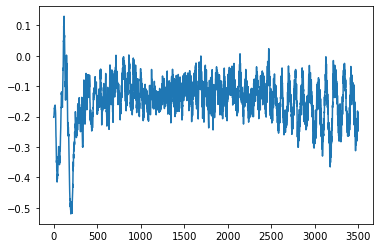

In [9]:
plt.plot(losses)
plt.show()

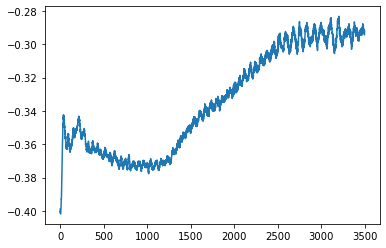

In [10]:
plt.plot(tranformed_privacies)
plt.show()

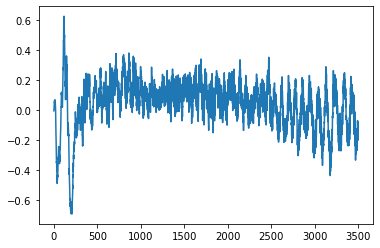

In [11]:
plt.plot(original_losses)
plt.show()

In [7]:
from utils.utils import load_models
model_ctgan = load_models('fpgan25', 'credit')

In [8]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [9]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [10]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.04692343]


## Fidelity

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = True)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = True)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [17]:
for i in y_syn:
    if i == 1:
        print(i)

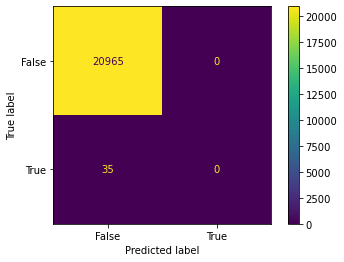

In [ ]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [ ]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [ ]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

In [ ]:
print(class1_ratio, class2_ratio)

20965 35


## Final plot

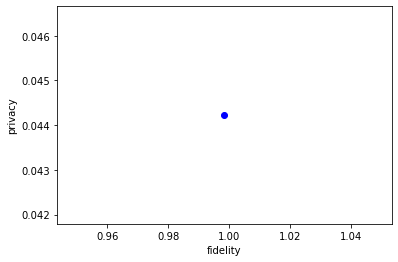

In [ ]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)